In [1]:
# Notebook vorbereiten
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil 
ab_ag_raw = pd.read_csv('data/ab_ag.tsv', sep='\t')
columns = pd.read_csv('data/columns.tsv', sep='\t')
uniprot_data = pd.read_csv('data/uniprot_data.tsv', sep='\t')

# ab_ag aus ab_ag_raw aufbereiten
ab_ag = ab_ag_raw[["pdb", "Hchain", "Lchain", "model", "antigen_chain", "antigen_name", "antigen_species","resolution"]].copy()
# Füge Spalten für die CDR-Sequenzen in ab_ag hinzu
for col in ["CDR_H1", "CDR_H2", "CDR_H3", "CDR_L1", "CDR_L2", "CDR_L3"]:
    if col not in ab_ag.columns:
        ab_ag[col] = np.nan
    ab_ag[col] = ab_ag[col].astype(object)
# Entferne Einträge ohne Antigennamen
ab_ag.dropna(subset=["antigen_chain"], inplace=True)

# Zeilen entfernen, bei denen resolution <= 3.5
ab_ag = ab_ag[ab_ag['resolution'] <= 3.5]
# Ich hab aus Versehen das Code-Feld gelöscht! Code von Anna für doppelte pdb Einträge zurückholen!

In [2]:
#### Überarbeiteter Code zum Herunterladen der Antikörpersequenzen. Nach dem Download wird der Code nicht mehr benötigt, da die Daten in ab_ag.tsv gespeichert werden.
## Funktionen aus dem sabdab_downloader importieren
#from common.sabdab_downloader import getannotation
#
## Definiere CDR-Regionen als slices für die H- und L-Ketten (Literatur überprüfen, ob die Indizes korrekt sind!)
#cdr_regions = {
#        "H1": slice(26, 32),
#        "H2": slice(52, 56),
#        "H3": slice(95, 102),
#        "L1": slice(24, 34),
#        "L2": slice(50, 56),
#        "L3": slice(89, 97)
#}
#
### Lade die Chothia-Daten und Chothia-nummerierten Sequenzen für jeden PDB-Eintrag herunter und speichere sie im Ordner des entsprechenden PDB-Eintrags:
## Für jede Zeile (bzw. Index, da einige Zeilen aus ab_ag_raw gelöscht wurden) in ab_ag
#for x in ab_ag.index:
#    # Extrahiere die PDB-ID, H-Kette, L-Kette und Modellnummer aus der Zeile für die Argumente von getannotation:
#    fab_unique = ab_ag.loc[x,["pdb", "Hchain", "Lchain", "model"]].tolist()
#    pdb = fab_unique[0] # PDB-ID aus der Liste extrahieren
#    # Erstelle einen temporären Ordner in sabdab_download, falls er noch nicht existiert für die files, die getannotation herunterladen wird
#    if not os.path.exists(f"data/sabdab_download/{pdb}"):
#        os.makedirs(f"data/sabdab_download/{pdb}")
#    # Lade die Chothia-nummerierten Sequenzen herunter oder gib eine Fehlermeldung für entsprechende PDB-Einträge aus.
#    # getanntation erwartet als zweites Argument eine Liste aus einer oder mehreren Listen. Wir benutzen pro Zeile in ab_ag jeweils eine Liste, die eine einzige Liste enthält:
#    try:
#        getannotation(pdb, [fab_unique], f"data/sabdab_download/{pdb}")
#        # Speichere die heruntergeladenen .ann-Dateien für VH und VL jeweils in einem DataFrame:
#        VH_chothia_seq = pd.read_csv(f"data/sabdab_download/{pdb}/{pdb}_{fab_unique[1]}_VH.ann", sep='\t', header=None, names=['Chothia_Position', 'Aminosäure'])
#        VL_chothia_seq = pd.read_csv(f"data/sabdab_download/{pdb}/{pdb}_{fab_unique[2]}_VL.ann", sep='\t', header=None, names=['Chothia_Position', 'Aminosäure'])
#        # Extrahiere die CDR-Sequenzen aus den Chothia-annotierten Sequenzen und speichere sie in ab_ag
#        H1_seq = VH_chothia_seq.loc[cdr_regions["H1"], "Aminosäure"].tolist()
#        ab_ag.at[x, "CDR_H1"] = H1_seq
#        H2_seq = VH_chothia_seq.loc[cdr_regions["H2"], "Aminosäure"].tolist()
#        ab_ag.at[x, "CDR_H2"] = H2_seq
#        H3_seq = VH_chothia_seq.loc[cdr_regions["H3"], "Aminosäure"].tolist()
#        ab_ag.at[x, "CDR_H3"] = H3_seq
#        L1_seq = VL_chothia_seq.loc[cdr_regions["L1"], "Aminosäure"].tolist()
#        ab_ag.at[x, "CDR_L1"] = L1_seq
#        L2_seq = VL_chothia_seq.loc[cdr_regions["L2"], "Aminosäure"].tolist()
#        ab_ag.at[x, "CDR_L2"] = L2_seq
#        L3_seq = VL_chothia_seq.loc[cdr_regions["L3"], "Aminosäure"].tolist()
#        ab_ag.at[x, "CDR_L3"] = L3_seq
#    except Exception as e:
#        print(f"Could not download Chothia-annotated sequence for {pdb}: {e}")
#    # Lösche den temporären Ordner, nachdem die Sequenzen extrahiert wurden:
#    shutil.rmtree(f"data/sabdab_download/{pdb}")
#ab_ag.to_csv('data/ab_ag_annotated.tsv', sep='\t', index=False)
##Achtung! Die Einträge der CDR Spalten in ab_ag sind Listen. .to_csv() kann keine Listen speichern, daher werden die Listen als Strings gespeichert!

In [3]:
#Kopie des annotated datensatzes erstellen
ab_ag_annotated_copy = pd.read_csv('data/ab_ag_annotated.tsv', sep='\t')
#anzahl der einträge vor der Löschung zur Kontrolle
count_beforedeletion = len(ab_ag_annotated_copy)
#löschung der einträge mit identischer sequenz
ab_ag_uniquesequences = ab_ag_annotated_copy.drop_duplicates(subset=['pdb', 'CDR_H1','CDR_H2','CDR_H3', 'CDR_L1', 'CDR_L2', 'CDR_L3'] )
#anzahl der einträge nach der löschung zur Kontrolle
duplicates_removed = count_beforedeletion - len(ab_ag_uniquesequences)
#mit f" können variablen in strings eingebaut werden
print(f"Anzahl gelöschter Einträge beträgt: {duplicates_removed}")

Anzahl gelöschter Einträge beträgt: 2494


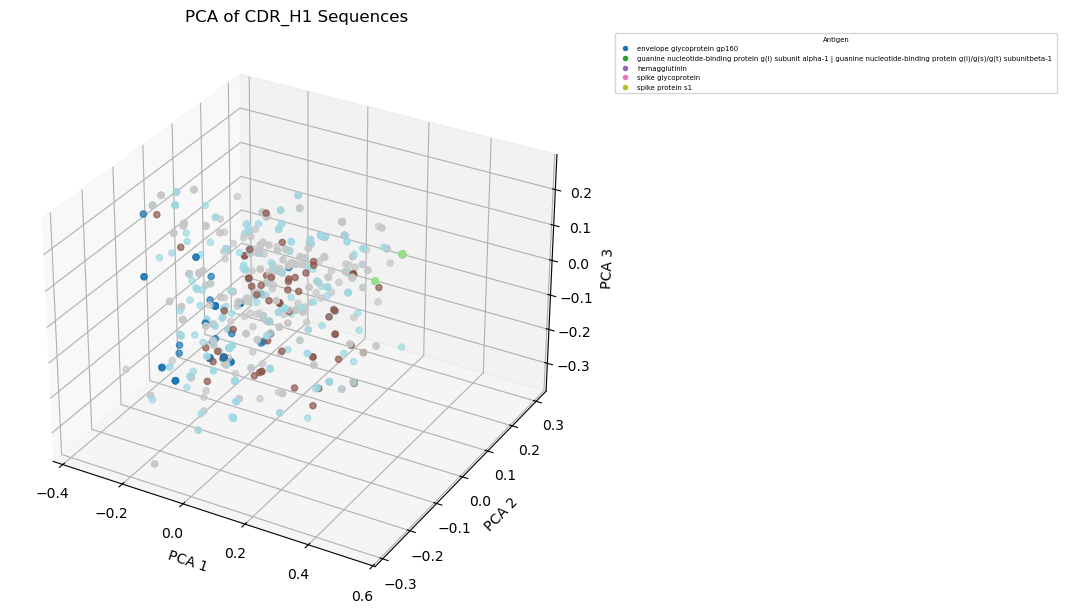

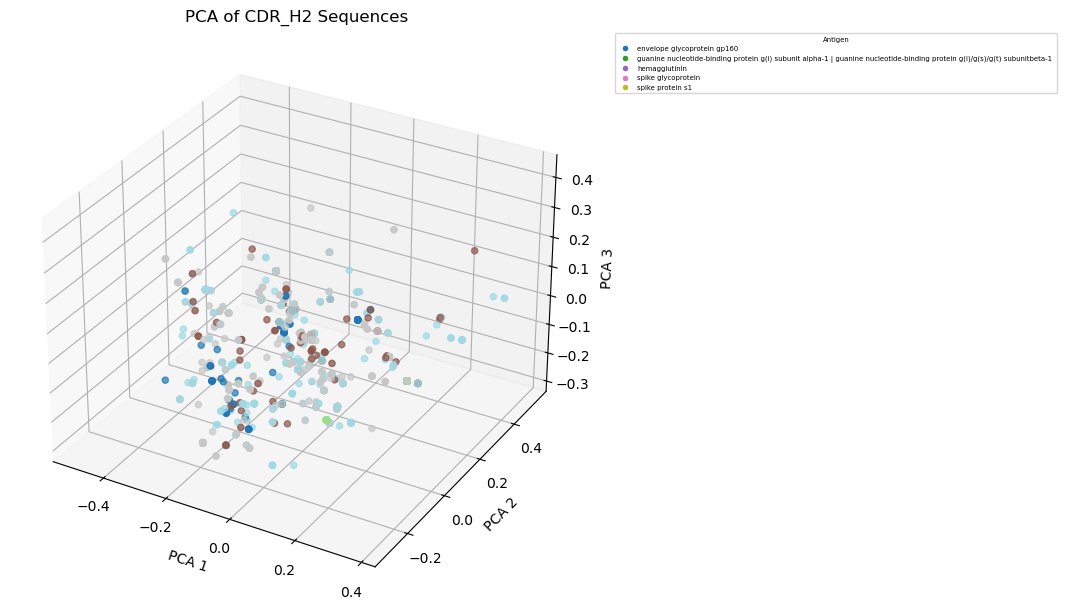

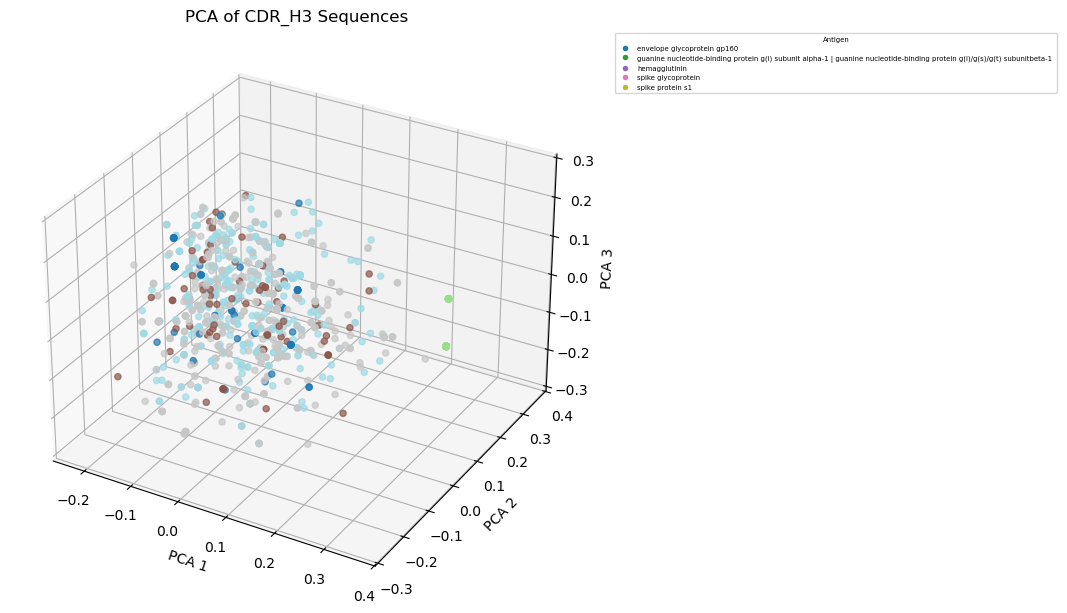

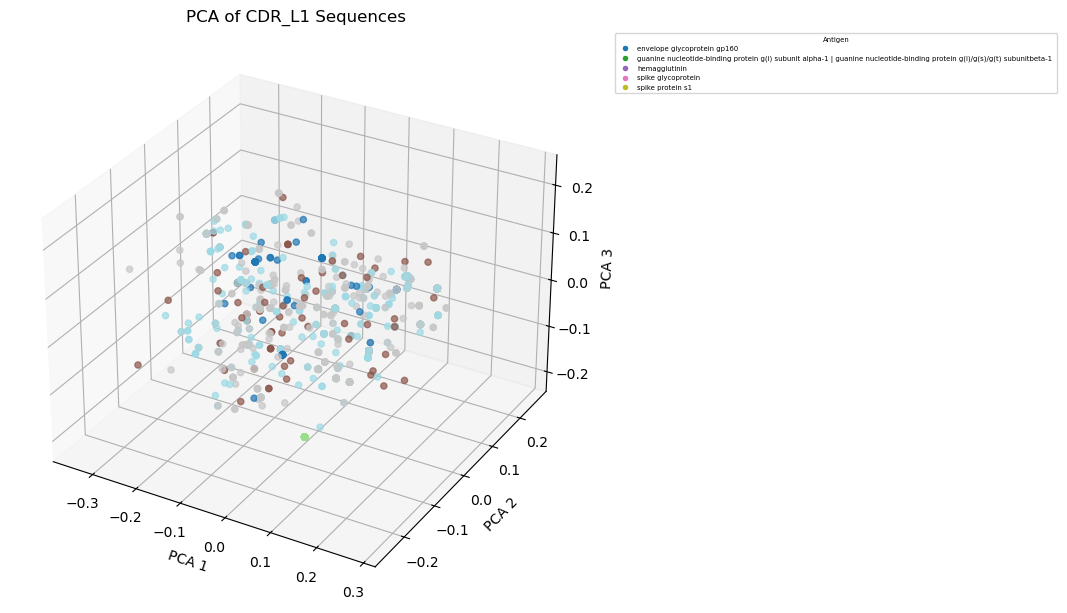

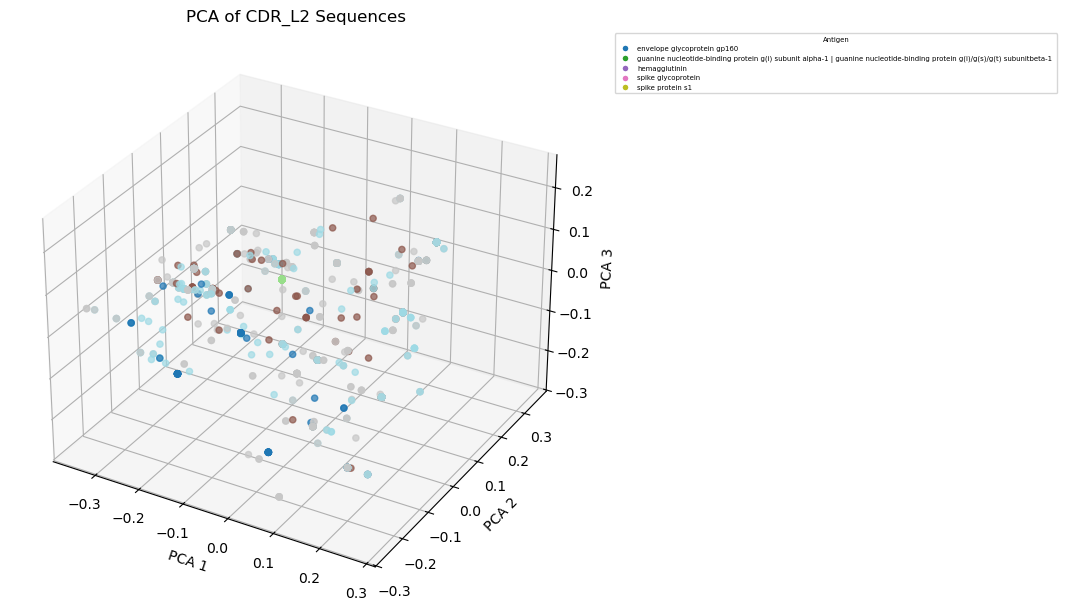

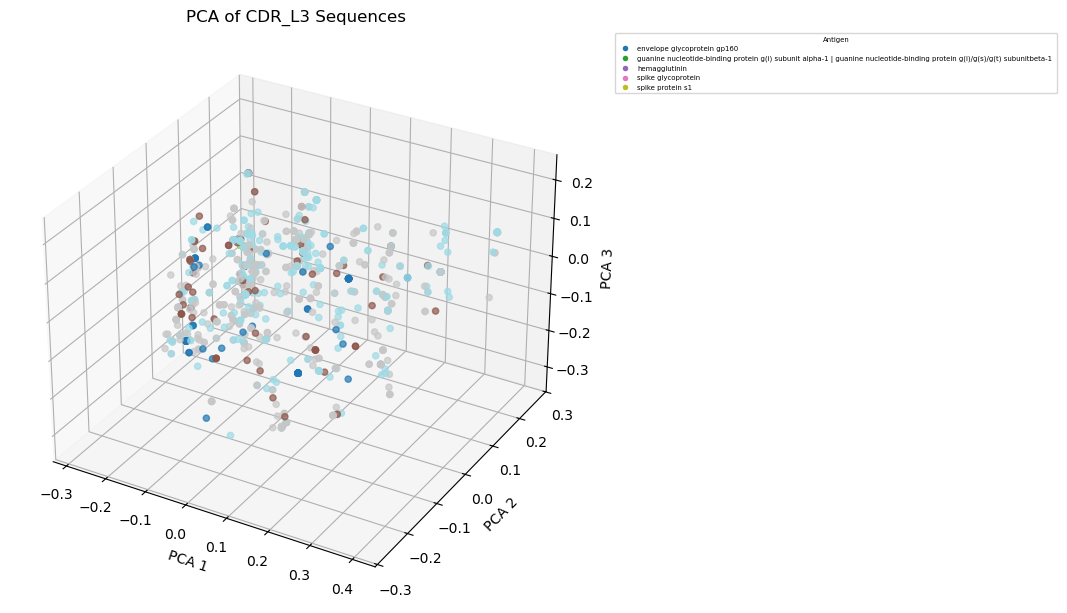

In [ ]:
# Zeilen für Color-Coding und Legende wurden nur reinkopiert und sind noch fehlerhaft! Nacharbeiten und verstehen!

import ast
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

def residue_percentage(sequence, residues):
    """
    Berechnet den prozentualen Anteil jeder Aminosäure in der gegebenen Sequenz und gibt eine Liste seq_residues zurück,
    die jede Aminosäure als Tupel (residue, percentage) enthält.
    sequence: list, die eine CDR-Sequenz repäsentiert, und deren Einträge aus einem String pro Aminosäure besteht, z.B. ['A', 'R', 'N', ...]
    residues: list, die alle proteinogenen Aminosäuren genau einmal als String enthält
    """
    seq_residues = []
    for residue in residues:
        percentage = sequence.count(residue) / len(sequence)
        seq_residues.append((residue, percentage))
    return seq_residues

def show_feature_space(feature_space, CDR_region, antigen):
    """
    Visualisiert den Feature-Space der CDR-Sequenzen mittels PCA in 3D.
    feature_space: pd.DataFrame, der die PDB-IDs in einer Spalte "pdb" und die prozentualen Anteile der Aminosäuren in den entsprechenden CDR-Sequenzen
    in je einer Spalte pro Aminosäure enthält.
    """
    X = feature_space.drop(columns=["pdb"])
    coords = PCA(n_components=3).fit_transform(X)
    
    # Color-Coding der Antigene
    antigen_categories = antigen.astype('category')
    color_codes = antigen_categories.cat.codes
    categories = antigen_categories.cat.categories

    # Plotten der PCA-Koordinaten in 3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c=color_codes, cmap='tab20', s=20, alpha=0.7)
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")
    ax.set_zlabel("PCA 3")
    ax.set_title(f"PCA of {CDR_region} Sequences")

    # Legende
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=cat,
                           markerfacecolor=plt.cm.tab20(i / len(categories)), markersize=5) for i, cat in enumerate(categories)]
    ax.legend(handles=handles, title="Antigen", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=5, title_fontsize=5)
    plt.tight_layout()
    plt.show()

# Bereite ab_ag_annotated vor
ab_ag_annotated = pd.read_csv('data/ab_ag_annotated.tsv', sep='\t')
ab_ag_annotated.drop_duplicates(subset=['pdb','CDR_H1','CDR_H2','CDR_H3', 'CDR_L1', 'CDR_L2', 'CDR_L3'], inplace=True) #Entferne identische Antikörper-Sequenzen mit gleichen PDB-IDs und CDR-Sequenzen
ab_ag_annotated.dropna(subset=['CDR_H1', 'CDR_H2', 'CDR_H3', 'CDR_L1', 'CDR_L2', 'CDR_L3'], inplace=True) #Entferne Einträge ohne CDR-Sequenzen
top_antigene = ab_ag_annotated["antigen_name"].value_counts().nlargest(5).index
ab_ag_annotated = ab_ag_annotated[ab_ag_annotated["antigen_name"].isin(top_antigene)].copy()
antigen = ab_ag_annotated["antigen_name"]

# Schleife über die CDR-Regionen, um den Feature-Space für jede CDR-Sequenz zu erstellen und zu visualisieren:
for CDR_region in ["CDR_H1", "CDR_H2", "CDR_H3", "CDR_L1", "CDR_L2", "CDR_L3"]:
    # pd.dataframe mit den PDB-IDs und CDR-Sequenzen erstellen. Einträge sind keine Listen, sondern Strings, die Listen repräsentieren (aufgrund der .to_csv()-Methode)!
    sequences = ab_ag_annotated[["pdb", CDR_region]].copy()
    # CDR-Sequenzen im pd.dataframe sequences von Strings in Listen umwandeln. Die .items() greift auf die Index-Eintrag-Paare des pd.dataframes sequences zu.
    for i, s in sequences[CDR_region].items(): #i= Index, s = String, l= Liste
        l = ast.literal_eval(s)
        sequences.at[i, CDR_region] = l
    
    # Liste aller einzigartigen, proteinogenen Aminosäuren erstelllen, die in den CDR-Sequenzen vorkommen. Wird als Argument für residue_percentage benötigt.
    sequences_list = sequences[CDR_region].tolist()
    residues = sorted(np.unique(np.concatenate(sequences_list)))

    # Leere Matrix für den Feature-Space vorbereiten. Enthält die PDB-IDs, aber noch keine prozentualen Anteile der Aminosäuren.
    feature_space = pd.DataFrame(columns=residues, index=sequences.index)
    feature_space.insert(0, "pdb", ab_ag_annotated["pdb"])
    
    # Berechne den prozentualen Anteil jeder Aminosäure in den CDR-Sequenzen und füge sie in den Feature-Space ein.
    for i in feature_space.index:
        sequence = sequences.at[i, CDR_region]
        seq_residues = residue_percentage(sequence, residues)
        for residue, percentage in seq_residues: # Für jedes Tupel (Residue, prozentualer Anteil) in der Liste seq_residues
            feature_space.at[i, residue] = percentage # Füge den prozentualen Anteil des Residues in der CDR-Sequenz in die entsprechende Spalte ein

    show_feature_space(feature_space, CDR_region, antigen)

In [7]:
print(ab_ag_annotated["antigen_name"].value_counts())

antigen_name
spike glycoprotein                                                                                                            469
spike protein s1                                                                                                              359
guanine nucleotide-binding protein g(i) subunit alpha-1 | guanine nucleotide-binding protein g(i)/g(s)/g(t) subunitbeta-1      82
hemagglutinin                                                                                                                  75
envelope glycoprotein gp160                                                                                                    66
envelope glycoprotein gp120                                                                                                    55
neuraminidase                                                                                                                  37
surface glycoprotein                                                         